### We check the conjecture of systems of the type $I\ddot{x} + B \dot{x} + K x = 0$, for the systems which have both B and K Lyapunov diagonally stable by finding counterexamples.

In [1]:
import numpy as np
from scipy.linalg import eig, solve_continuous_lyapunov

# Function to generate a random Lyapunov diagonally stable matrix
def generate_lyapunov_diagonally_stable_matrix(n):
    """
    We generate Lyapunov diagonally stable matrices based on the convergent theorem.
    """
    t = np.random.rand(n) # inverse of the M matrix
    v = np.random.exponential(scale=1, size=n)
    u = np.random.exponential(scale=1, size=n)
    W = np.random.exponential(scale=1, size=(n, n))
    mat = np.diag(1 / t) - W @ np.diag(u / (v + W @ u))
    return mat

# Function to calculate the block Jacobian matrix
def block_jacobian_matrix(B, K):
    """
    Define the block Jacobian matrix for the system I*ddot{x} + B*dot{x} + K*x = 0.
    B: Damping matrix
    K: Stiffness matrix
    """
    n = B.shape[0]
    # Construct the block matrix
    zero_block = np.zeros((n, n))
    A = np.block([
        [zero_block, np.eye(n)],
        [- K, - B]
    ])
    return A

In [2]:
n = 2
num_trials = 1000

for trial in range(num_trials):
    # Generate Lyapunov diagonally stable matrices B and K
    B = generate_lyapunov_diagonally_stable_matrix(n)
    K = generate_lyapunov_diagonally_stable_matrix(n)
    # K = np.diag(np.random.exponential(scale=1, size=n))
    
    # Define the block Jacobian matrix
    J = block_jacobian_matrix(B, K)
    
    # Find eigenvalues
    eigenvalues = np.linalg.eigvals(J)
    
    # Check if all real parts are negative
    if np.all(np.real(eigenvalues) < 0):
        pass
    else:
        print(f"Trial {trial + 1}: System is unstable, eigenvalues: {eigenvalues}")
        break

Trial 78: System is unstable, eigenvalues: [-2.51467163+1.88360964j -2.51467163-1.88360964j  0.30180392+0.30146793j
  0.30180392-0.30146793j]


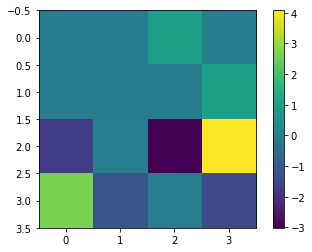

In [3]:
# imshow the jacobian
import matplotlib.pyplot as plt
plt.imshow(J)
plt.colorbar()
plt.show()

In [4]:
np.linalg.eigvals(B)

array([3.03941094, 1.38632449])

In [5]:
np.linalg.eigvals(K)

array([1.81381665, 0.99034976])

### We check Flaviano's pertubative solution and add it to the ORGaNICs module.

In [7]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import math
from perturbed_organics.spectrum_general import matrix_solution
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
from perturbed_organics.utils.util_funs import dynm_fun
import numpy as np
from joblib import Parallel, delayed, parallel_backend
import os
from matplotlib import colors
from scipy.optimize import fsolve, curve_fit
from scipy import integrate
import warnings


# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
cmap = 'viridis'

In [8]:
"""Define the parameters of the ORGaNICs"""
N = 100
params = {
    'N_y': N,
    'N_a': N,
    'eta': 0.02,
    'noise_type': 'additive'
}
b0 = 0.5 * torch.ones(N)
b1 = 0.5 * torch.ones(N)
sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [9]:
def sample_sparse_matrix(N, c, delta, mu):
    mask = torch.bernoulli(torch.full((N, N), c / N)).triu()
    values = torch.normal(mu, delta, (N, N))
    upper_triangular = values * mask
    #symmetric_matrix = upper_triangular + upper_triangular.T - torch.diag(torch.diag(upper_triangular))
    symmetric_matrix = torch.bernoulli(torch.full((N, N), c / N))*torch.normal(mu, delta, (N, N))
    return symmetric_matrix

In [10]:
mu = 0.0
c = 1.0 * N # sparsity
delta = 0.15

Wyy = torch.eye(N) + sample_sparse_matrix(N, c, delta, mu)
# count the number of non-zero elements
non_zero = torch.sum(Wyy != 0)

print(f'Sparsity of the matrix is {non_zero / N**2:.2f}')

# make the input drive to be ones 
gamma = 0.9
z = torch.ones(N)
# make z to be norm gamma
z = z / torch.norm(z) * gamma

Sparsity of the matrix is 1.00


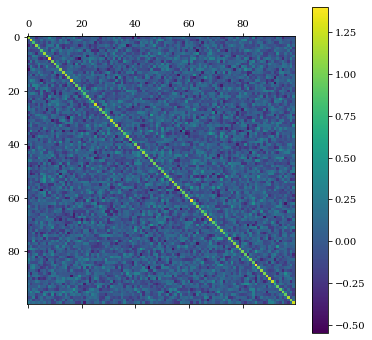

In [11]:
# imshow the matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.matshow(Wyy, cmap=cmap)
fig.colorbar(cax)
plt.show()

In [24]:
# start at a different initial condition

initial_type = "first_order"
# initial_type = "norm"
Wyy = torch.eye(N) 
# find the fixed point of the model
model = organics.ORGaNICs2Dgeneral(params=params, b0=b0, b1=b1, sigma=sigma, tauA=tauA, tauY=tauY, Wyy=Wyy, Way=Way, z=z, initial_type=initial_type, run_jacobian=True)
